***
# Web Scraping Project - Analyzing ClassPass.com
### Created By: Arezoo Tirdad
***

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import random
from time import sleep
import random
from bs4 import BeautifulSoup
import requests
import glob

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
driver = webdriver.Chrome('C:/Users/arezo/OneDrive/Desktop/WCD/B3_Python/chromedriver.exe')

C:\Users\arezo\AppData\Local\Temp\ipykernel_28396\2143881686.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/arezo/OneDrive/Desktop/WCD/B3_Python/chromedriver.exe')


### Making a  request & soup object
The webpage is written as a Single Page Application so going into the next pages doesn't change the web adderss. For this reason, using Selenium, a soup object was created from each page source while we loop through a list of dates to get the desired class schedules for a week.

The website authomatically shows the classes and studios within a certain distance from the city which the member chooses during the registeration process. In this case, the city is Oakville, ON and no more filteration was done in order to capture as many results as possible.

In [3]:
url = 'https://classpass.com/'
driver.get(url)
sleep(2)

#### Logging in

In [4]:
driver.find_element(By.LINK_TEXT,'Log in').click()

In [5]:
email_input = driver.find_element(By.XPATH,'//*[@id="email_field"]')
email_input.send_keys("...")

In [6]:
password_input = driver.find_element(By.XPATH,'//*[@id="password_field"]')
password_input.send_keys("...")

In [7]:
driver.find_element(By.XPATH,'//*[@id="content"]/main/div/div/div[1]/div/div/form/ul/li[3]/button/span').click()

#### Closing pop-up

In [8]:
element = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CLASS_NAME, '_3pG4dMRuG3tL2RZXB4FMv')))
element.click()

#### Going one day forward at a time to get to desired date

In [9]:
# first_day has to be at least one day forward to capture all the classes starting from 12:00 AM
first_day = 'Thu, Jan 5'
date_on_page = driver.find_element(By.XPATH, '//*[@id="Selector_3_Selection"]/span').text

while first_day != date_on_page:
    driver.find_element(By.XPATH, '//*[@id="content"]/header/div/section/ul/li[3]/div/div[3]/button').click()
    date_on_page = driver.find_element(By.XPATH, '//*[@id="Selector_3_Selection"]/span').text
    print(date_on_page)
    sleep(random.randint(2,6))

Thu, Jan 5


In [10]:
# Creating BeautifulSoup object of the 1st page to be scraped
page_source = driver.page_source
soup = BeautifulSoup(page_source)

### Creating csv files of the schedule on each page for each day of the week
- printing number of files as we loop through the pages.
- creating a dictionary of studio addresses and appending to it as we loop separately from the main DataFrame. This is because there are obviously less studios than classes and significantly helped with the web crawler as opening & closing of new tabs resulted in the site being crashed a couple of times, even while using this approach. Still, all the addresses were scraped as the crawler had less address to scrape as we go through the dates & also would get other chances if not successful.

In [ ]:
address_dict = dict()

In [ ]:
data = []

captured_dates = ['Thu, Jan 5', 'Fri, Jan 6', 'Sat, Jan 7', 'Sun, Jan 8', 'Mon, Jan 9', 'Tue, Jan 10', 'Wed, Jan 11']

# Initializing the first date to be scraped
# The id below changed several times during the course of writing the notebook, the number would be either 3, 5 or 8 so double
# checking this before running the notebook is recommended.
date_scraped = driver.find_element(By.XPATH, '//*[@id="Selector_3_Selection"]/span').text
num = 1

while date_scraped in captured_dates:
    
    for (enum, tag) in enumerate(soup.find_all('li', class_='_3vk1F9nlSJQIGcIG420bsK')):
        
        try:
            # Double check the id below before ruuning to match above
            date = driver.find_element(By.XPATH, '//*[@id="Selector_3_Selection"]/span').text.split(', ')[1] + ', 2023'        
            studio_info = [item.text for item in list(tag.find('div', class_='MXnMQhcQgDmf3Q0Q1yfRy').children)]
            studio_name = studio_info[0]
            neighbourhood = studio_info[1]
            category = studio_info[2]
            time = tag.find('div', class_='bCs_Uv4OzvLAJ__kdBmZV').time.text
            duration = int(tag.find('div', class_='bCs_Uv4OzvLAJ__kdBmZV').text.split('M')[1].replace(' min', ''))
            class_name = tag.find('div', class_='_1eEFCYjRA2LDiu1CY2kgCE').h2.get('title')
            rating = float(tag.find('a', class_='_1WKdVg6eg-_ZGw-97Q7jNd').text.split('(')[0])
            reviews = tag.find('a', class_='_1WKdVg6eg-_ZGw-97Q7jNd').text.split('(')[1].replace(')', '').replace('+', '')
            credit = int(tag.find('div', class_='_1M3hQIOGsT6vyhq4pl6Jpn').span.text)
            
        except:
            date = 'N/A'
            studio_name = 'N/A'
            neighbourhood = 'N/A'
            category = 'N/A'
            time = 'N/A'            
            duration = 'N/A'
            class_name = 'N/A'
            rating = 'N/A'
            reviews = 'N/A'
            credit = 'N/A'
            
        # Checking if we have the address and scrape it from studio page which opens on a new tab.
        # We ONLY do this if we don't have the address already as there are far less studios than classes.
        if studio_name not in address_dict.keys():
            
            original_window = driver.current_window_handle
            assert len(driver.window_handles) == 1
            
            # Click the link for that studio which opens in a new tab
            driver.find_elements(By.CLASS_NAME, '_2ysARFXywRbdfUNTCQ54u2')[enum].click()
            sleep(random.randint(3,5))
            
            # Wait for the new window or tab
            WebDriverWait(driver, 10).until(EC.number_of_windows_to_be(2))

            # Loop through until we find a new window handle
            for window_handle in driver.window_handles:
                if window_handle != original_window:
                    driver.switch_to.window(window_handle)
                    break

            # Wait for the new tab to finish loading content
            sleep(random.randint(3,5))

            try:
                # Close pop-up
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, '_2LRPXDaHVVHkgVf6HQPBcR')))
                element.click()
                sleep(random.randint(2,10))
                
                # Get address from new page
                address = driver.find_element(By.CLASS_NAME, '_7PFYNQ5sk4nOrtcbS_Kfr').text
                address_dict[studio_name] = address
                
            except:
                address = 'break'
                
            #Close the tab or window
            driver.close()
            #Switch back to the old tab or window
            driver.switch_to.window(original_window)
            sleep(random.randint(2,10))
            
        data.append({'date': date,
                     'studio_name': studio_name,
                     'neighbourhood': neighbourhood,
                     'time': time,
                     'duration': duration,
                     'class_name': class_name,
                     'category': category,
                     'rating': rating,
                     'reviews': reviews,
                     'credit': credit
                    })
                     
    pd.DataFrame(data).to_csv(f'data-{date_scraped}-{num}.csv', mode = 'w')
    print(f'{date_scraped}-file-{num}')
    data = []
        
    # going to the next page on the same date
    try:
        driver.find_element(By.XPATH, '//*[@id="Search_Results"]/div[1]/div/div/nav/button[2]/span').click()
        num += 1
    except:
        driver.find_element(By.XPATH, '//*[@id="content"]/header/div/section/ul/li[3]/div/div[3]/button/div/span').click()
        num += 1
        
    # waiting for the new page to load
    sleep(random.randint(3,10))
    # reassigning date(necessary when we go a day forward)(match the number in id to date-scraped above)
    date_scraped = driver.find_element(By.XPATH, '//*[@id="Selector_3_Selection"]/span').text
        
    # making soup object from the new page
    page_source = driver.page_source
    soup = BeautifulSoup(page_source)

In [ ]:
address_df = pd.DataFrame(address_dict.values(), index = address_dict.keys(), columns = ['address'])
address_df.to_csv('address_df.csv')

### Using glob library to combine all csv files into one DataFrame

In [2]:
# Get csv files list from a folder
path = 'C:/Users/arezo/OneDrive/Desktop/WCD/assignments/Web Scraping/final_files'
csv_files = glob.glob(path + '/*.csv')

# Read each csv file into DataFrame, to create a list of DataFrames
df_list = []
for file in csv_files:
    sub_df = pd.read_csv(file, index_col=0)
    df_list.append(sub_df)

# Concatenate all DataFrames
df = pd.concat(df_list, ignore_index = True)

#### Investigating key aspects of the final DataFrame

In [3]:
df.shape

(1720, 10)

In [4]:
df.head(10)

,date,studio_name,neighbourhood,time,duration,class_name,category,rating,reviews,credit
0,"Jan 6, 2023",Momentum Fitness · George Street,NaN,12:00 AM,120,Open Gym,Gym Time,4.7,7.0,2.0
1,"Jan 6, 2023",Momentum Fitness · George Street,NaN,1:00 AM,120,Open Gym,Gym Time,4.7,7.0,1.0
2,"Jan 6, 2023",Momentum Fitness · George Street,NaN,2:00 AM,120,Open Gym,Gym Time,4.7,7.0,2.0
3,"Jan 6, 2023",Momentum Fitness · George Street,NaN,3:00 AM,120,Open Gym,Gym Time,4.7,7.0,2.0
4,"Jan 6, 2023",Momentum Fitness · George Street,NaN,4:00 AM,120,Open Gym,Gym Time,4.7,7.0,2.0
5,"Jan 6, 2023",Functional Strength Wellness,Burlington,5:00 AM,120,Functional Strength,Strength Training,4.5,2.0,2.0
6,"Jan 6, 2023",Amazing Fitness,NaN,5:00 AM,120,Open Gym,Gym Time,4.4,5.0,2.0
7,"Jan 6, 2023",Momentum Fitness · George Street,NaN,5:00 AM,120,Open Gym,Gym Time,4.7,7.0,1.0
8,"Jan 6, 2023",Reid Method Pilates,NaN,6:00 AM,60,Pilates Session,Pilates,5.0,1.0,36.0
9,"Jan 6, 2023",MADabolic · Burlington,Burlington,6:00 AM,50,WORK. REST. REPEAT.,Strength Training,4.8,500.0,2.0


In [5]:
df.info()
# Many of the classes don't have info under neighbourhood

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720 entries, 0 to 1719
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1720 non-null   object 
 1   studio_name    1720 non-null   object 
 2   neighbourhood  739 non-null    object 
 3   time           1720 non-null   object 
 4   duration       1720 non-null   int64  
 5   class_name     1720 non-null   object 
 6   category       1712 non-null   object 
 7   rating         1598 non-null   float64
 8   reviews        1598 non-null   float64
 9   credit         1706 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 134.5+ KB


In [6]:
address_df = pd.read_csv('address_df.csv', index_col = 0)
address_df.head()

,address
Functional Strength Wellness,"4087 Harvester Road, Burlington, ON, L7L 0C1"
MADabolic · Burlington,"1860 Appleby Line, Unit 13, Burlington, ON, L7..."
Reid Method Pilates,"3105 Unity Drive, Mississauga, ON, L5L 4L2"
Altitude Athletic Training,"56 Colborne Street, Toronto, ON, M5E 1E3"
Sweat and Tonic,"225 Yonge Street, Toronto, ON, M5B 1N8"


In [7]:
df = df.set_index('studio_name')
df = df.join(address_df)
df.head()

,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address
9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"


In [8]:
# checking the length of DataFrame after joining
len(df)

1720

In [9]:
# resetting back the studio_name 
df = df.reset_index(drop = False).rename(columns = {'index':'studio_name'})
df.head()

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address
0,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
1,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
2,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
3,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"
4,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9"


## Cleaning/manipulating the data

In [10]:
# Adding a city column
df['city'] = df['address'].str.split(', ').str[-3]

#### Adding a price column by multiplying credit by 2.3 which would be the value of 1 credit assuming the defaul membership of $69/month

In [11]:
df['price($)'] = df['credit'] * 2.3
df.head()

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($)
0,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9
1,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9
2,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9
3,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9
4,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9


#### Finding out how many studios don't show price/credit info and decide if necessary to drop them

In [12]:
df['credit'].isnull().sum()

14

In [13]:
df[(df['credit'].isnull() == True)]['studio_name'].value_counts()
# Referencing the website, these classes mostly belong to one studio which only opens reservation window 3 days in advance, 
# They will not have meaningful impact in analyzing the whole dataset and can be dropped later

Stay Gold                      13
Brass Belles  · Mississauga     1
Name: studio_name, dtype: int64

#### Adding a column, by combining date and time of each calss, in a datetime format

In [14]:
# Adding a column, by combining date and time of each calss, with a datetime format
df['datetime'] = df['date']+' '+ df['time']
df['datetime'] = pd.to_datetime(df['datetime'], format = '%b %d, %Y %I:%M %p')
df.head()

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($),datetime
0,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:00:00
1,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:45:00
2,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 08:30:00
3,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 09:15:00
4,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 10:00:00


#### find out number of studios that do not have location info under neighbourhood

In [15]:
df[df['neighbourhood'].isnull() == True]['studio_name'].nunique()

59

In [16]:
# looking up their names
# Some of the studios have several branches. They are identified in the studio_name by a middle dot ' · ' and a location 
# identifier (name of city or neighbourhood or street). This identifier is used in the webpage address of each studio but 
# since it doesnn't have a consistant format, a webpage address couldn't be generated. 

df[df['neighbourhood'].isnull() == True]['studio_name'].value_counts()

Momentum Fitness  · George Street                138
Reid Method Pilates                              125
Amazing Fitness                                   88
Physion Dynamics                                  53
BuffBoy Fitness Personal Training                 38
Solis Movement                                    29
Modo Yoga  · Hamilton - Dundas                    28
Modo Yoga · Hamilton - Stoney Creek               27
Crossfit Stoney Creek                             26
The Toronto Barre Collective                      25
Altitude Athletic Training                        25
Atlas Boxing & Fitness Ctr.                       22
Brass Belles  · Mississauga                       21
Freestyle Dojo                                    21
Bao Institute                                     20
Strength Camp                                     20
Stay Gold                                         19
Resilience Yoga                                   18
Mukti Studio                                  

#### Correcting the name of city for two addresses that do not include province & postal code in their address so the split didn't result in the name of the city.

In [17]:
df['city'] = df['city'].str.replace('1312 King Street West', 'Toronto')
df[df['studio_name'].str.contains('Body By Chosen · Toronto') == True]

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($),datetime
230,Body By Chosen · Toronto,"Jan 9, 2023",Downtown,7:00 AM,60,Lower Body Strength,Strength Training,4.5,2.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-09 07:00:00
231,Body By Chosen · Toronto,"Jan 9, 2023",Downtown,7:00 PM,60,Full Body Strength,Strength Training,4.7,21.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-09 19:00:00
232,Body By Chosen · Toronto,"Jan 7, 2023",Downtown,10:00 AM,45,Cardio & Core,Strength Training,4.8,5.0,3.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,6.9,2023-01-07 10:00:00
233,Body By Chosen · Toronto,"Jan 7, 2023",Downtown,11:00 AM,45,Strength & Endurance,Strength Training,5.0,7.0,3.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,6.9,2023-01-07 11:00:00
234,Body By Chosen · Toronto,"Jan 5, 2023",Downtown,7:00 AM,60,Full Body Shredz,Strength Training,4.8,5.0,3.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,6.9,2023-01-05 07:00:00
235,Body By Chosen · Toronto,"Jan 5, 2023",Downtown,6:00 PM,60,Boxing,Boxing,5.0,65.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-05 18:00:00
236,Body By Chosen · Toronto,"Jan 10, 2023",Downtown,7:00 AM,60,H.I.I.T Full Body,Strength Training,4.8,5.0,3.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,6.9,2023-01-10 07:00:00
237,Body By Chosen · Toronto,"Jan 10, 2023",Downtown,6:00 PM,45,H.I.I.T,Strength Training,4.9,19.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-10 18:00:00
238,Body By Chosen · Toronto,"Jan 11, 2023",Downtown,7:00 AM,45,Strength & Conditioning,Strength Training,5.0,10.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-11 07:00:00
239,Body By Chosen · Toronto,"Jan 11, 2023",Downtown,7:00 PM,60,Booty Build,Strength Training,5.0,27.0,2.0,"1312 King Street West, Toronto, M6K 1G8",Toronto,4.6,2023-01-11 19:00:00


In [18]:
df['city'] = df['city'].str.replace('1230 Sheppard Avenue West Unit 2', 'North York')
df[df['studio_name'].str.contains('Atlas Boxing & Fitness Ctr.') == True]

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($),datetime
127,Atlas Boxing & Fitness Ctr.,"Jan 6, 2023",NaN,12:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-06 12:00:00
128,Atlas Boxing & Fitness Ctr.,"Jan 6, 2023",NaN,5:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,2.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,4.6,2023-01-06 17:00:00
129,Atlas Boxing & Fitness Ctr.,"Jan 6, 2023",NaN,6:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-06 18:00:00
130,Atlas Boxing & Fitness Ctr.,"Jan 6, 2023",NaN,7:00 PM,60,ATLAS Boxing Academy,Boxing,5.0,1.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-06 19:00:00
131,Atlas Boxing & Fitness Ctr.,"Jan 9, 2023",NaN,12:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-09 12:00:00
132,Atlas Boxing & Fitness Ctr.,"Jan 9, 2023",NaN,5:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,2.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,4.6,2023-01-09 17:00:00
133,Atlas Boxing & Fitness Ctr.,"Jan 9, 2023",NaN,6:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-09 18:00:00
134,Atlas Boxing & Fitness Ctr.,"Jan 9, 2023",NaN,7:00 PM,60,ATLAS Boxing Academy,Boxing,5.0,1.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-09 19:00:00
135,Atlas Boxing & Fitness Ctr.,"Jan 9, 2023",NaN,8:00 PM,60,ATLAS Box-FIT,Boxing,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-09 20:00:00
136,Atlas Boxing & Fitness Ctr.,"Jan 7, 2023",NaN,10:00 AM,60,ATLAS Circuit,Strength Training,5.0,2.0,3.0,"1230 Sheppard Avenue West Unit 2, North York, ...",North York,6.9,2023-01-07 10:00:00


## Analysis/visualization

In [19]:
df.head()

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($),datetime
0,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:00:00
1,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:45:00
2,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 08:30:00
3,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 09:15:00
4,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 10:00:00


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720 entries, 0 to 1719
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   studio_name    1720 non-null   object        
 1   date           1720 non-null   object        
 2   neighbourhood  739 non-null    object        
 3   time           1720 non-null   object        
 4   duration       1720 non-null   int64         
 5   class_name     1720 non-null   object        
 6   category       1712 non-null   object        
 7   rating         1598 non-null   float64       
 8   reviews        1598 non-null   float64       
 9   credit         1706 non-null   float64       
 10  address        1720 non-null   object        
 11  city           1720 non-null   object        
 12  price($)       1706 non-null   float64       
 13  datetime       1720 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(8)
memory usage: 188.

In [21]:
# Which type of exercises are offered the most?
df['category'].value_counts()

Strength Training                           471
Yoga                                        375
Gym Time                                    241
Pilates                                     199
Boxing                                      147
Martial Arts                                 64
Personal Training                            55
Dance                                        38
Cycling                                      31
Barre                                        23
Stretching                                   18
Yoga, Outdoors                               11
Pilates, Yoga                                11
Aerial                                        7
Strength Training, Running                    6
Stretching, Yoga                              4
Running                                       3
Gym Time, Boxing                              3
Prenatal                                      1
Strength Training, Outdoors                   1
Yoga, Strength Training                 

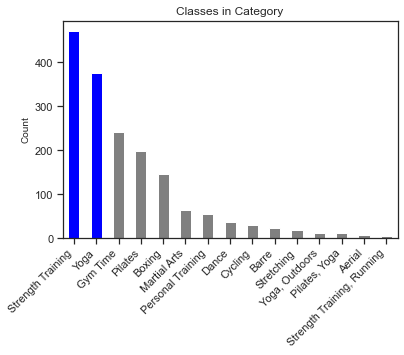

In [22]:
colors = ['blue']*2 + ['grey']*21

df['category'].value_counts().head(15).plot(kind='bar', title= 'Classes in Category', color = colors)
#plt.xlabel(fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

In [23]:
# How many workout categories are there?
df['category'].nunique()

23

In [24]:
# How many studios do we have?
df['studio_name'].nunique()

116

In [25]:
# How many studios are there in each city?
df.groupby(['city'])['studio_name'].nunique().sort_values(ascending = False)

city
Toronto        58
Mississauga    16
Hamilton       14
Burlington     10
Brampton        5
Oakville        4
Etobicoke       2
Grimsby         2
Carlisle        1
Dundas          1
Georgetown      1
Milton          1
North York      1
Name: studio_name, dtype: int64

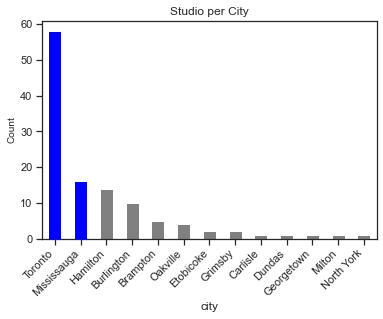

In [26]:
colors = ['blue']*2 + ['grey']*11

df.groupby(['city'])['studio_name'].nunique().sort_values(ascending = False) \
.plot(kind='bar', title= 'Studio per City', color = colors)
#plt.xlabel(fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

In [27]:
# which cities offer the most classes?
df.groupby(['city'])['class_name'].count().sort_values(ascending = False)

city
Toronto        546
Hamilton       378
Mississauga    324
Burlington     237
Oakville        91
Brampton        58
North York      22
Etobicoke       21
Georgetown      20
Dundas          10
Grimsby          9
Milton           3
Carlisle         1
Name: class_name, dtype: int64

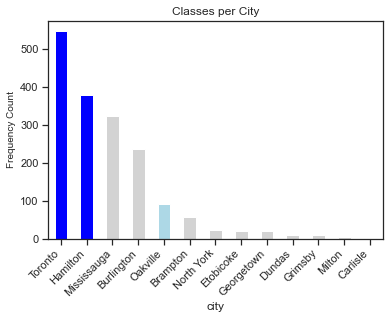

In [28]:
colors = ['blue']*2 + ['lightgrey']*2 + ['lightblue'] + ['lightgrey']*8

df.groupby('city')['class_name'].count().sort_values(ascending = False).plot(kind='bar', title= 'Classes per City', color=colors)
plt.xlabel('city', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency Count', fontsize = 10);

In [29]:
# Combining the two Groupbys above:
nums_per_city = df.groupby('city')[['studio_name', 'class_name']].aggregate({'studio_name':'nunique', 'class_name':'count'})\
.sort_values(by=['class_name'], ascending=False).rename(columns={'studio_name':'studio_count', 'class_name':'class_count'})
nums_per_city['class/studio'] = (nums_per_city['class_count'] / nums_per_city['studio_count']).round(2)
nums_per_city

,studio_count,class_count,class/studio
city,,,
Toronto,58,546,9.41
Hamilton,14,378,27.00
Mississauga,16,324,20.25
Burlington,10,237,23.70
Oakville,4,91,22.75
Brampton,5,58,11.60
North York,1,22,22.00
Etobicoke,2,21,10.50
Georgetown,1,20,20.00


In [30]:
# which studios offer most of the classes? where are they located?
most_active_studios = df[['city', 'studio_name']].value_counts().head(16)
most_active_studios

city         studio_name                        
Hamilton     Momentum Fitness  · George Street      138
Mississauga  Reid Method Pilates                    125
Burlington   Functional Strength Wellness            99
Hamilton     Amazing Fitness                         88
Mississauga  Physion Dynamics                        53
Oakville     Inye Yoga                               47
Mississauga  BuffBoy Fitness Personal Training       38
Toronto      Modo Yoga · Bloor West                  36
Oakville     iGita Yoga & Pilates                    35
Toronto      Solis Movement                          29
Burlington   Red Owl Boxing · Burlington             29
             MADabolic · Burlington                  28
Hamilton     Modo Yoga  · Hamilton - Dundas          28
Burlington   Be Yoga & Wellness                      27
Hamilton     Modo Yoga · Hamilton - Stoney Creek     27
             Crossfit Stoney Creek                   26
dtype: int64

In [31]:
# What is the average price/credit in each workout category?
df.groupby('category')[['credit', 'price($)']].mean().round(2).sort_values(by = ['price($)'], ascending = False)

,credit,price($)
category,,
Pilates,23.70,54.51
Personal Training,16.64,38.26
"Strength Training, Running",7.00,16.10
Aerial,6.71,15.44
Running,4.33,9.97
Stretching,3.22,7.41
"Yoga, Strength Training",3.00,6.90
Dance,2.78,6.40
Cycling,2.77,6.38


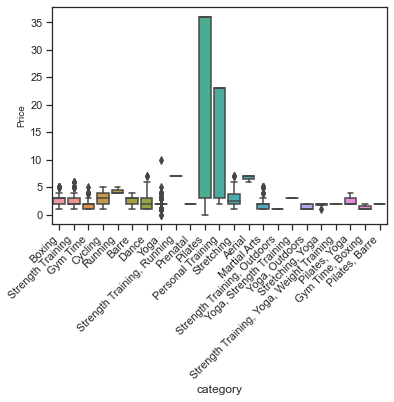

In [32]:
sns.boxplot(x = 'category', y = 'credit', data = df)
plt.xlabel('category', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.suptitle('')
plt.ylabel('Price', fontsize = 10);

In [33]:
# Finding Pilates classes and avg price per studio
pilatesClasses = df[df['category'] == 'Pilates'][['city','studio_name', 'class_name', 'price($)']]
#pilatesClasses.sort_values(by = ['price($)'] , ascending = False)
pilatesClasses.groupby(['studio_name', 'class_name', 'city']).agg({'price($)':'mean'}).sort_values(by=['price($)'], ascending=False).head(15)

,,,price($)
studio_name,class_name,city,
Reid Method Pilates,Pilates Session,Mississauga,82.800000
BeHot Yoga Toronto,Hot Hiit 45 Pilates,Toronto,18.400000
Studio Lagree · Queen East,M3 FUSION (QUEEN),Toronto,13.225000
Coloured Soul Yoga & Wellness,Slow Burn Pilates,Etobicoke,11.500000
Studio Lagree & KO · King Street West,M3 FUSION (King St.),Toronto,11.500000
Sweat and Tonic,"Mat Pilates, Hot",Toronto,9.200000
Studio Zee Pilates · Downtown,Reformer All Levels,Hamilton,9.200000
Coloured Soul Yoga & Wellness,PiYo®,Etobicoke,9.200000
Imprint Pilates,IN STUDIO 55min Pilates Matwork Instruction (L1/2) - upstairs,Toronto,7.666667


In [34]:
# what are the top 10 most popular studios? and what is the average price?
df.groupby(['studio_name']).aggregate({'reviews': 'mean', 'rating':'mean', 'price($)': 'max'}) \
.round(2).sort_values(by='reviews', ascending= False).head(10)

,reviews,rating,price($)
studio_name,,,
Studio Lagree · Queen East,5000.00,4.90,13.8
barre3 · Toronto,4166.67,4.77,9.2
Elle Fitness and Social,3374.43,4.71,6.9
Studio Lagree & KO · King Street West,2571.43,4.87,11.5
Imprint Pilates,2500.00,4.60,11.5
United Boxing Club,2083.67,4.75,6.9
SPINCO · Downtown,1750.00,4.80,6.9
BeHot Yoga Toronto,1500.00,4.77,23.0
Pure Yoga Toronto,1320.00,4.82,4.6


In [35]:
# Which category of classes are popular based on review and rating?
df2 = df.groupby(['category']).agg({'class_name':'count', 'reviews': 'mean', 'rating':'mean'}).round(2) \
.sort_values(by='reviews', ascending= False).rename(columns = {'class_name': 'Number of Classes', 'reviews': 'Avg_Reviews', 'rating':'Avg_Rating'})
df2

,Number of Classes,Avg_Reviews,Avg_Rating
category,,,
Barre,23,816.17,4.67
Cycling,31,652.74,4.72
"Strength Training, Running",6,428.67,4.90
"Pilates, Yoga",11,418.55,4.90
Pilates,199,251.43,4.95
Yoga,375,178.54,4.76
Boxing,147,162.10,4.83
Strength Training,471,103.39,4.77
Prenatal,1,100.00,4.60


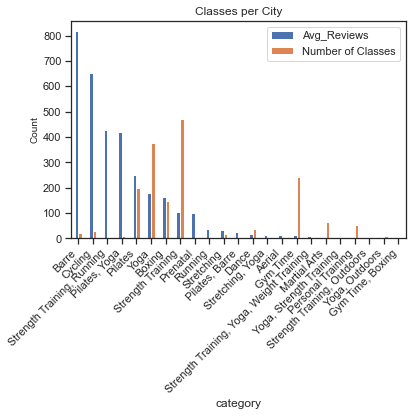

In [36]:
df2[['Avg_Reviews', 'Number of Classes']].plot(kind='bar', title= 'Classes per City')
plt.xlabel('category', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

category
Strength Training    471
Yoga                 375
Gym Time             241
Pilates              199
Name: Number of Classes, dtype: int64

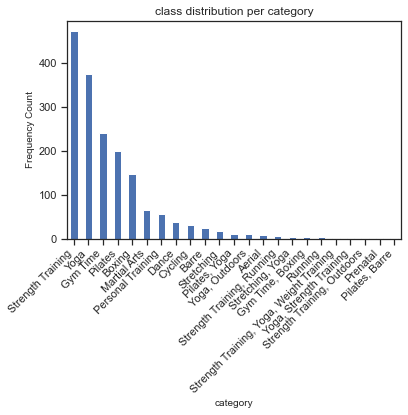

In [38]:
df2['Number of Classes'].sort_values(ascending = False).plot(kind='bar', title= 'class distribution per category')
plt.xlabel('category', fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequency Count', fontsize = 10);
df4=df2['Number of Classes'].sort_values(ascending = False).head(4)
df4

In [39]:
# Which are the most cost-effective classes?
df[['datetime', 'class_name', 'duration', 'studio_name', 'price($)']].sort_values(by = ['price($)']).head(10)

,datetime,class_name,duration,studio_name,price($)
1707,2023-01-05 19:30:00,FREE Class | Hatha Yoga,60,iGita Yoga & Pilates,0.0
418,2023-01-05 19:15:00,Community Yoga - Free + Donation *In Studio,60,Downward Dog Yoga,0.0
1467,2023-01-08 10:00:00,Build and Burn Community Class - Cash ONLY/In-...,60,Studio Zee Pilates · Downtown,0.0
853,2023-01-10 06:30:00,Hot Hatha,60,Modo Yoga · Hamilton - Stoney Creek,2.3
851,2023-01-08 08:30:00,*Modo 60,60,Modo Yoga · Hamilton - Stoney Creek,2.3
848,2023-01-09 20:00:00,*SSU 60,60,Modo Yoga · Hamilton - Stoney Creek,2.3
785,2023-01-11 20:00:00,*SSU 60,60,Modo Yoga · Hamilton - Dundas,2.3
784,2023-01-11 18:30:00,*Modo Flow,60,Modo Yoga · Hamilton - Dundas,2.3
781,2023-01-11 09:30:00,*Slow Flow 60,60,Modo Yoga · Hamilton - Dundas,2.3
779,2023-01-10 20:00:00,*SSU 60,60,Modo Yoga · Hamilton - Dundas,2.3


In [40]:
# Which are the most expensive classes?
df.groupby(['class_name', 'studio_name']).agg({'price($)':'max'}).sort_values(by = ['price($)'], ascending = False).head(10)

,,price($)
class_name,studio_name,
Pilates Session,Reid Method Pilates,82.8
Personal Training Session,BuffBoy Fitness Personal Training,52.9
Original Hot Yoga 90,BeHot Yoga Toronto,23.0
Hot Hiit 45 Pilates,BeHot Yoga Toronto,18.4
Lyra Hoop (All Levels),Brass Belles · Mississauga,16.1
Slow Burn Pilates,Coloured Soul Yoga & Wellness,16.1
Introduction to Pole Dance - My First Ever Pole Class,Brass Belles · Mississauga,16.1
Flex-Ability Stretch class,Brass Belles · Mississauga,16.1
Aerial Silks (All Levels),Brass Belles · Mississauga,16.1


##### On average, is there a meaningful difference between prices on weekends vs weekdays during working hours and after?

In [41]:
df['weekend'] = ['yes' if (value == 'Saturday' or value == 'Sunday') else 'no' for value in df['datetime'].dt.day_name()]

In [42]:
weekends = df[df['weekend'] == 'yes']
round(weekends['price($)'].mean(), 2)

4.89

In [43]:
weekday_9to5 = df[(df['datetime'].dt.hour < 17) & (df['datetime'].dt.hour > 9) & (df['weekend'] == 'no')]
round(weekday_9to5['price($)'].mean(), 2)

22.55

In [44]:
weekday_after5 = df[(df['weekend'] == 'no') & (df['datetime'].dt.hour > 17)]
round(weekday_after5['price($)'].mean(), 2)

6.61

In [45]:
# Is there a price difference between weekend vs weekday?
df.groupby(['weekend'])['price($)'].agg('mean')

weekend
no     13.749647
yes     4.893448
Name: price($), dtype: float64

In [46]:
# Is there a price difference between weekend vs weekday?
# Once you look at the same numbers within each city, it seems there are not that much difference except for Mississauga
df.groupby(['weekend', 'city'])['price($)'].agg('mean').unstack()

city,Brampton,Burlington,Carlisle,Dundas,Etobicoke,Georgetown,Grimsby,Hamilton,Milton,Mississauga,North York,Oakville,Toronto
weekend,,,,,,,,,,,,,
no,6.900000,4.674595,4.6,3.614286,8.688889,3.577778,4.6,3.852297,4.6,45.389796,5.931579,4.502817,6.735000
yes,7.155556,4.688462,NaN,2.300000,9.200000,3.450000,4.6,3.389474,NaN,7.137931,6.900000,4.830000,5.734247


In [47]:
# What is the average price in each city?
df.groupby(['city'])['price($)'].agg('mean').sort_values(ascending = False)
# need a box plot chart to see if outliers are skewing results in Missassauga
# also a bar chart of this average price vs number of classes(Hamilton offers a lot of classes while very cost effective)

city
Mississauga    41.955418
Etobicoke       8.761905
Brampton        6.939655
Toronto         6.597936
North York      6.063636
Burlington      4.677637
Carlisle        4.600000
Grimsby         4.600000
Milton          4.600000
Oakville        4.574725
Hamilton        3.735979
Georgetown      3.565000
Dundas          3.220000
Name: price($), dtype: float64

In [48]:
# Searching for the studio in Mississauga which seems to move the averages significantly
classesInMississauga = df[df['city'] == 'Mississauga'][['studio_name', 'class_name', 'price($)', 'date', 'time']]
#classesInMississauga.sort_values(by = ['price($)'] , ascending = False)
classesInMississauga.groupby('studio_name').agg({'price($)':'mean'})
# There are two studios offering Pilates & personal training which are far more expensive than the rest, skewing the average price

,price($)
studio_name,
Body By Chosen · Mississauga,6.900000
Brass Belles · Mississauga,14.950000
BuffBoy Fitness,6.900000
BuffBoy Fitness Personal Training,52.900000
"Chakde- Art, Dance & Fitness",2.300000
Konga Fitness,8.912500
Legacy Stronghold,5.558333
Physion Dynamics,8.115094
Primal Performance Coaching,6.133333


In [49]:
# Searching for the studio in Mississauga which seems to move the averages significantly
pilatesInMississauga = df[(df['category'] == 'Pilates') & (df['city'] == 'Mississauga')]\
[['studio_name', 'class_name', 'price($)', 'date', 'time']]
pilatesInMississauga.sort_values(by = ['price($)'] , ascending = False)
pilatesInMississauga.groupby('studio_name').agg({'price($)':'mean'})

,price($)
studio_name,
Quiet Bodies,6.242857
Reid Method Pilates,82.800000


In [50]:
# df3 is a filteration of top 5 cities
#df.groupby(['city'])['class_name'].count().sort_values(ascending = False)
Top5City=df[(df['city'] == 'Toronto') | (df['city'] == 'Hamilton') |(df['city'] == 'Mississauga') |(df['city'] == 'Burlington') |(df['city'] == 'Oakville')]

In [51]:
Top5City.head()

,studio_name,date,neighbourhood,time,duration,class_name,category,rating,reviews,credit,address,city,price($),datetime,weekend
0,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:00:00,no
1,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,7:45 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 07:45:00,no
2,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,8:30 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 08:30:00,no
3,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,9:15 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 09:15:00,no
4,9Round Fitness · Downtown Toronto,"Jan 5, 2023",Richmond Hill,10:00 AM,45,Kickboxing circuit training,Boxing,4.7,100.0,3.0,"320 Richmond Street East, Toronto, ON, M5A 2P9",Toronto,6.9,2023-01-05 10:00:00,no


In [53]:
# df4 is a filteration on df2(class count per category)
df4=df2['Number of Classes'].sort_values(ascending = False).head(4)
df4

category
Strength Training    471
Yoga                 375
Gym Time             241
Pilates              199
Name: Number of Classes, dtype: int64

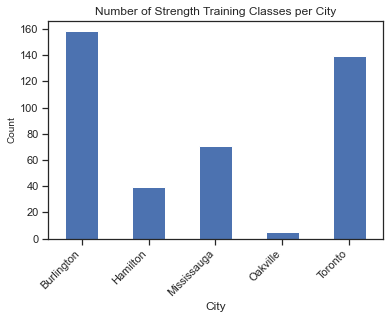

In [54]:
TopCities_straining = Top5City[Top5City['category'] == 'Strength Training'].groupby('city')['class_name'].count()
TopCities_straining.plot(kind='bar', title='Number of Strength Training Classes per City')
plt.xlabel('City', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

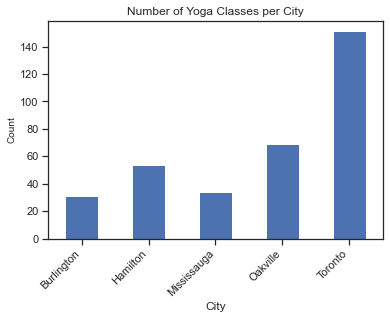

In [55]:
TopCities_yoga = Top5City[Top5City['category'] == 'Yoga'].groupby('city')['class_name'].count()
TopCities_yoga.plot(kind='bar', title='Number of Yoga Classes per City')
plt.xlabel('City', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

Burlington       0
Oakville         0
Mississauga      0
Hamilton       226
Toronto         15
dtype: int64

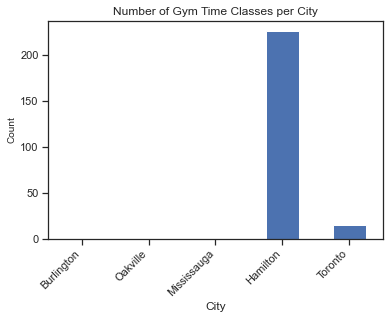

In [56]:
TopCities_gymtime = Top5City[Top5City['category'] == 'Gym Time'].groupby('city')['class_name'].count()
temp=pd.Series({'Burlington':0, 'Oakville':0, 'Mississauga':0})
TopCities_gymtime = pd.concat([temp, TopCities_gymtime])

TopCities_gymtime.plot(kind='bar', title='Number of Gym Time Classes per City')
plt.xlabel('City', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);

TopCities_gymtime

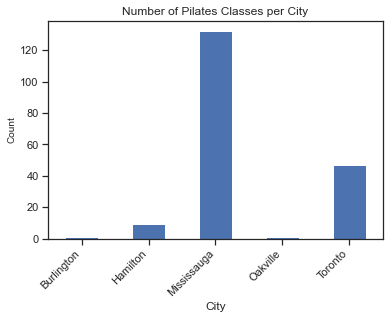

In [57]:
TopCities_pilates = Top5City[Top5City['category'] == 'Pilates'].groupby('city')['class_name'].count()
TopCities_pilates.plot(kind='bar', title='Number of Pilates Classes per City')
plt.xlabel('City', fontsize = 12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count', fontsize = 10);